# Training a neural network on MNIST with Keras

This simple example demonstrate how to plug TFDS into a Keras model.


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
tf.enable_v2_behavior()

In [2]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()

dataset_path = "s3://{}/{}/".format(bucket, "tensorflow-datasets")
print(dataset_path)


s3://sagemaker-ap-northeast-1-042083552617/tensorflow-datasets/


## Step 1: Create your input pipeline

Build efficient input pipeline using advices from:
* [TFDS performance guide](https://www.tensorflow.org/datasets/performances)
* [tf.data performance guide](https://www.tensorflow.org/guide/data_performance#optimize_performance)


### Load MNIST

Load with the following arguments:

* `shuffle_files`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised`: Returns tuple `(img, label)` instead of dict `{'image': img, 'label': label}`

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    data_dir=dataset_path,
    with_info=True,
)

AbortedError: All 10 retry attempts failed. The last failure: Unknown: : No response body.

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset mnist downloaded and prepared to /home/ec2-user/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


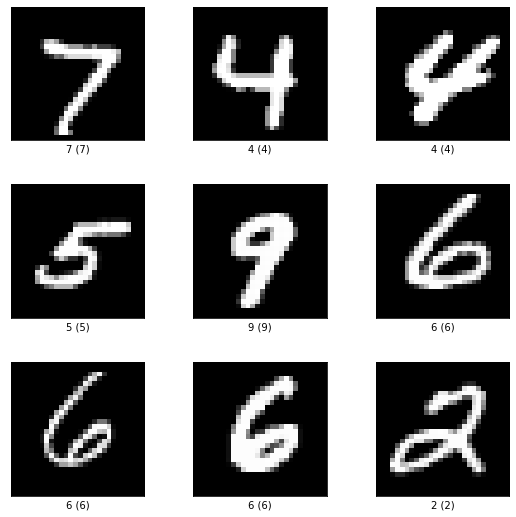

In [5]:
fig = tfds.show_examples(ds_test, ds_info)

In [6]:
ds = ds_train.take(1)

for image, label in ds:
  print(image.dtype, image.shape)



<dtype: 'uint8'> (28, 28, 1)


### Build training pipeline

Apply the following transormations:

* `ds.map`: TFDS provide the images as tf.uint8, while the model expect tf.float32, so normalize images
* `ds.cache` As the dataset fit in memory, cache before shuffling for better performance.<br/>
__Note:__ Random transformations should be applied after caching
* `ds.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For bigger datasets which do not fit in memory, a standard value is 1000 if your system allows it.
* `ds.batch`: Batch after shuffling to get unique batches at each epoch.
* `ds.prefetch`: Good practice to end the pipeline by prefetching [for performances](https://www.tensorflow.org/guide/data_performance#prefetching).

In [7]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

In [8]:
# split begins
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [9]:
ds = ds_train.take(1)

for image, label in ds:
  print(image.dtype)
  print(image.shape)


<dtype: 'float32'>
(28, 28, 1)


In [10]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
# split ends

In [ ]:
# before split
# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(128)
# ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

### Build evaluation pipeline

Testing pipeline is similar to the training pipeline, with small differences:

 * No `ds.shuffle()` call
 * Caching is done after batching (as batches can be the same between epoch)

In [11]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Step 2: Create and train the model

Plug the input pipeline into Keras.

In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [13]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [ ]:
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6


In [ ]:
model.summary()


In [ ]:
model.save('my_model') 

In [17]:
model.save('my_model.h5') 